In [1]:
# Try to understand Zackay+Ofek paper II

In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,8)
from matplotlib.patches import Polygon
import pylab as plt
import numpy as np
import fitsio
from astrometry.util.fits import *
from astrometry.util.util import Tan
from astrometry.util.plotutils import *
from astrometry.libkd.spherematch import match_radec
from collections import Counter
from astrometry.util.starutil import *
from scipy.ndimage.filters import *
from scipy.ndimage.measurements import label, find_objects
from scipy.ndimage.morphology import binary_dilation, binary_fill_holes

In [329]:
H,W = 64,64 #256,256
psf_s1 = 2.
psf_s2 = 4.
F1 = 1.
F2 = 1.
sig_1 = 1.
sig_2 = 1.
xx,yy = np.meshgrid(np.arange(W), np.arange(H))
cx,cy = W//2, H//2
cx1 = cx
cx2 = cx
img1 = np.exp(-0.5 * ((xx-cx1)**2 + (yy-cy)**2)/psf_s1**2)
img1 /= np.sum(img1)
img2 = np.exp(-0.5 * ((xx-cx2)**2 + (yy-cy)**2)/psf_s2**2)
img2 /= np.sum(img2)

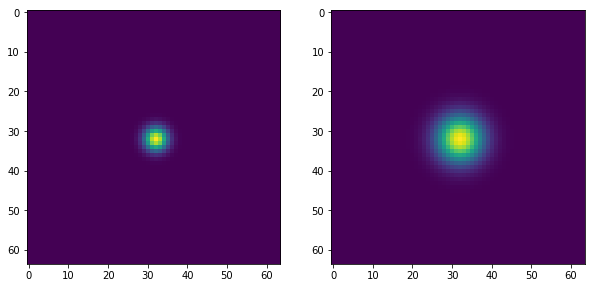

In [330]:
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2);

In [331]:
psf1 = img1
psf2 = img2

In [332]:
P1 = np.fft.rfft2(psf1)
P1.dtype
print(P1.real.min(), P1.real.max())
print(P1.imag.min(), P1.imag.max())
P2 = np.fft.rfft2(psf2)
P2.dtype
print(P2.real.min(), P2.real.max())
print(P2.imag.min(), P2.imag.max())

-0.9809080339138543 1.0
-2.205423072897811e-15 1.946481712790382e-15
-0.9257914512036213 1.0
-2.118856305688421e-15 1.968911145233676e-15


In [333]:
# Image FFTs = PSF FFTs
M1 = P1
M2 = P2

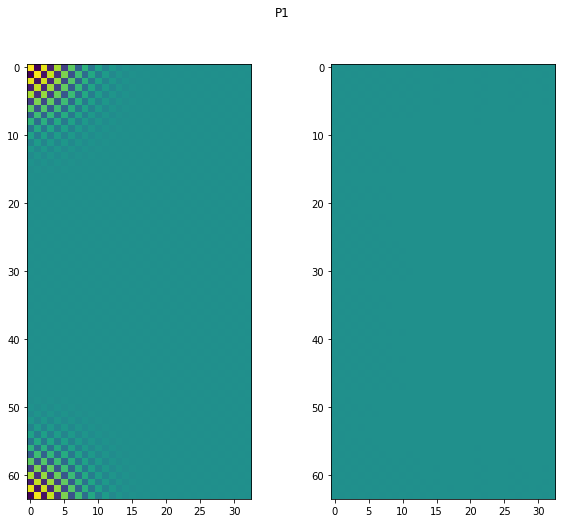

In [334]:
plt.subplot(1,2,1)
plt.imshow(P1.real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow(P1.imag, vmin=-1, vmax=1)
plt.suptitle('P1');

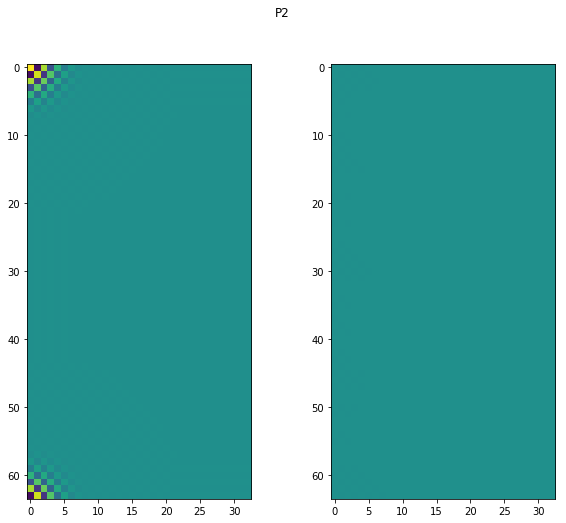

In [335]:
plt.subplot(1,2,1)
plt.imshow(P2.real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow(P2.imag, vmin=-1, vmax=1)
plt.suptitle('P2');

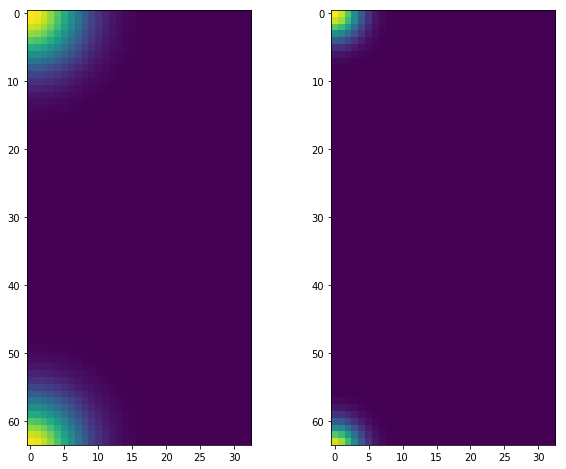

In [336]:
plt.subplot(1,2,1)
plt.imshow(np.abs(P1), vmin=0, vmax=1)
plt.subplot(1,2,2)
plt.imshow(np.abs(P2), vmin=0, vmax=1);

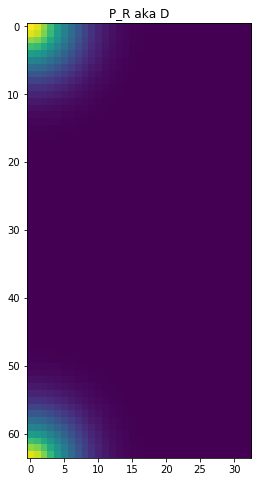

In [367]:
D = np.sqrt((F1**2 / sig_1**2) * np.abs(P1)**2 + (F2**2 / sig_2**2) * np.abs(P2)**2)
plt.imshow(D)
plt.title('P_R aka D');

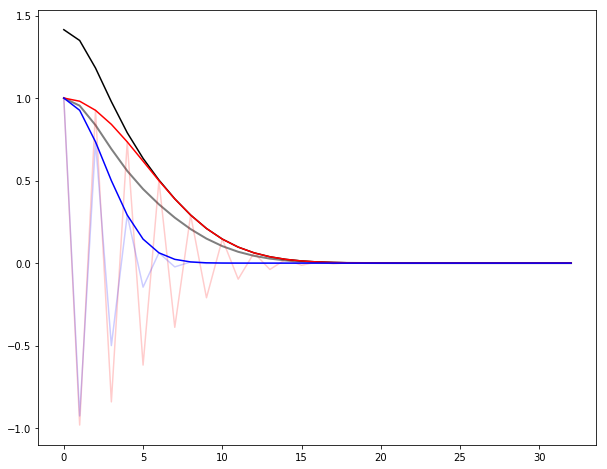

In [601]:
plt.plot(D[0,:], 'k-');
plt.plot(D[0,:]/D[0,0], 'k-', lw=2, alpha=0.5);
plt.plot(P1[0,:].real, 'r-', alpha=0.2);
plt.plot(np.abs(P1[0,:]), 'r-');
plt.plot(P2[0,:].real, 'b-', alpha=0.2);
plt.plot(np.abs(P2[0,:]), 'b-');

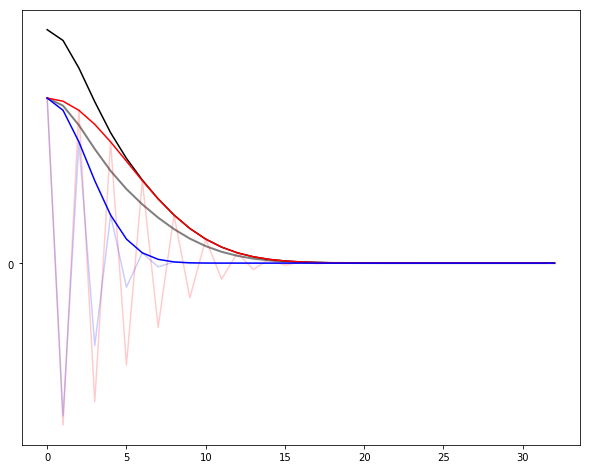

In [603]:
plt.plot(D[0,:], 'k-');
plt.plot(D[0,:]/D[0,0], 'k-', lw=2, alpha=0.5);
plt.plot(P1[0,:].real, 'r-', alpha=0.2);
plt.plot(np.abs(P1[0,:]), 'r-');
plt.plot(P2[0,:].real, 'b-', alpha=0.2);
plt.plot(np.abs(P2[0,:]), 'b-');
plt.yscale('symlog', lin)

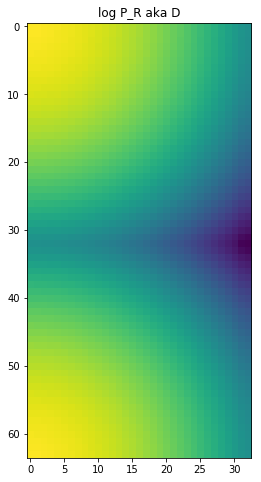

In [602]:
plt.imshow(np.log10(D))
plt.title('log P_R aka D');

In [369]:
N = (F1 / sig_1**2) * (P1 * M1) + (F2 / sig_2**2) * (P2 * M2)

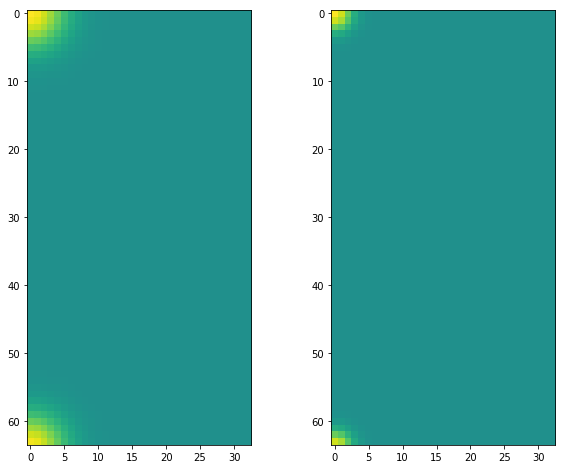

In [370]:
plt.subplot(1,2,1)
plt.imshow((P1 * M1).real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow((P2 * M2).real, vmin=-1, vmax=1);

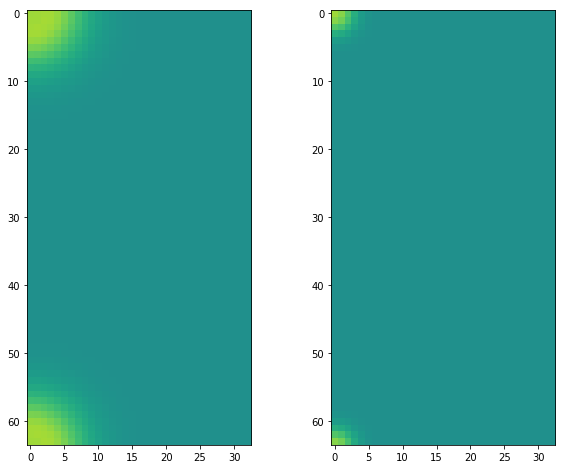

In [510]:
plt.subplot(1,2,1)
plt.imshow((P1 * M1 / D).real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow((P2 * M2 / D).real, vmin=-1, vmax=1);

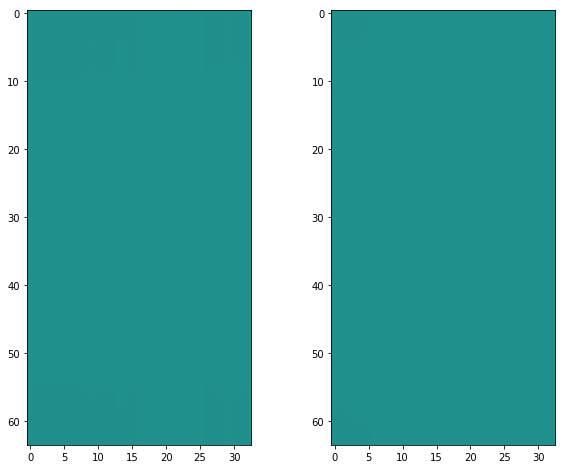

In [511]:
plt.subplot(1,2,1)
plt.imshow((P1 * M1 / D).imag, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow((P2 * M2 / D).imag, vmin=-1, vmax=1);

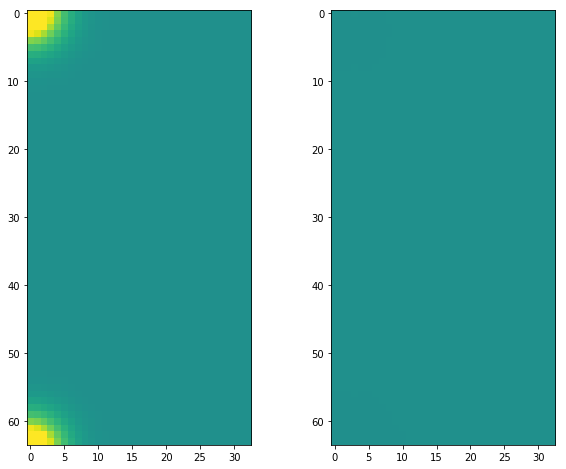

In [371]:
plt.subplot(1,2,1)
plt.imshow(N.real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow(N.imag, vmin=-1, vmax=1);

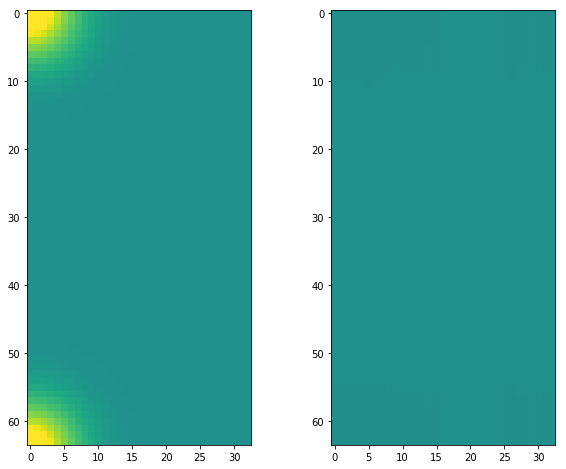

In [372]:
plt.subplot(1,2,1)
plt.imshow((N/D).real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow((N/D).imag, vmin=-1, vmax=1);

In [668]:
R = N/D
print(R.dtype, R.shape)
imgR = np.fft.irfft2(R)
imgR = np.fft.ifftshift(imgR)
print(imgR.dtype, imgR.shape)
Counter(np.sign(imgR).ravel())

complex128 (64, 33)
float64 (64, 64)


Counter({1.0: 2220, -1.0: 1876})

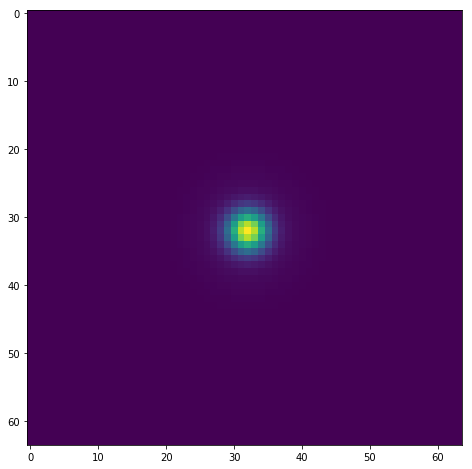

In [392]:
plt.imshow(imgR);

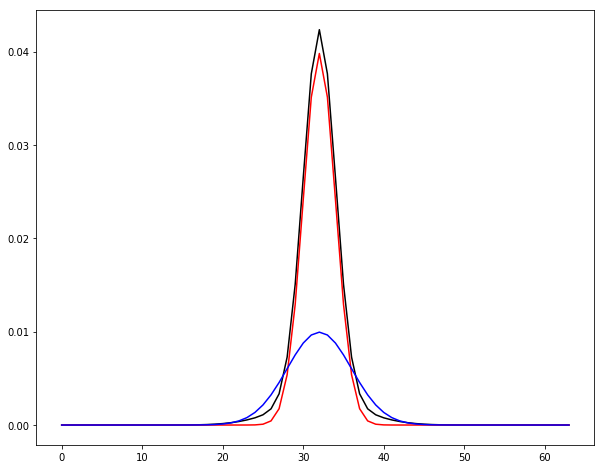

In [393]:
plt.plot(imgR[cy,:], color='k')
plt.plot(img1[cy,:], color='r')
plt.plot(img2[cy,:], color='b');

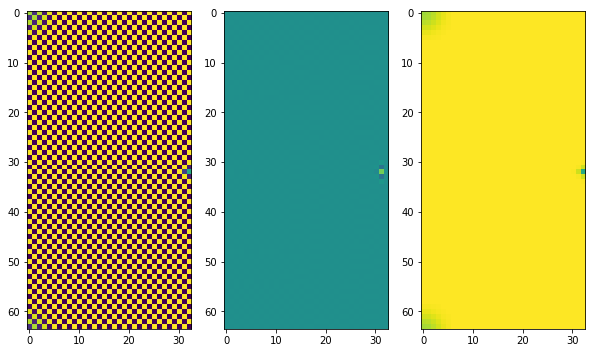

In [501]:
plt.subplot(1,3,1)
plt.imshow((P1 / D).real, vmin=-1, vmax=1)
plt.subplot(1,3,2)
plt.imshow((P1 / D).imag, vmin=-1, vmax=1)
plt.subplot(1,3,3)
plt.imshow(np.abs(P1 / D), vmin=-1, vmax=1);

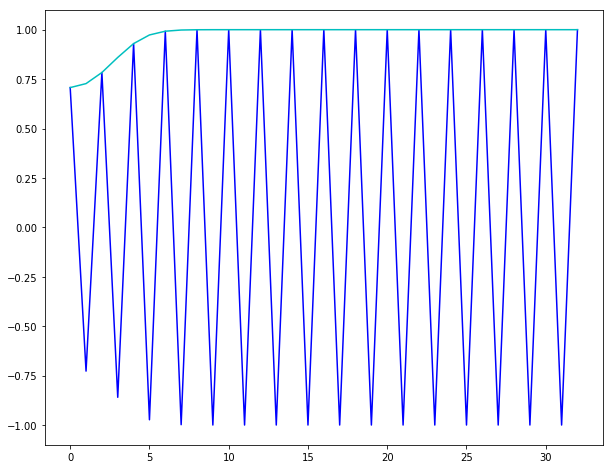

In [382]:
plt.plot((P1/D).real[0,:], 'b-')
plt.plot(np.abs(P1/D)[0,:], 'c-');

In [605]:
# ic1 is the effective convolution kernel to go from img1 to R
ic1 = np.fft.irfft2(P1/D)
ic1.dtype, ic1.shape

(dtype('float64'), (64, 64))

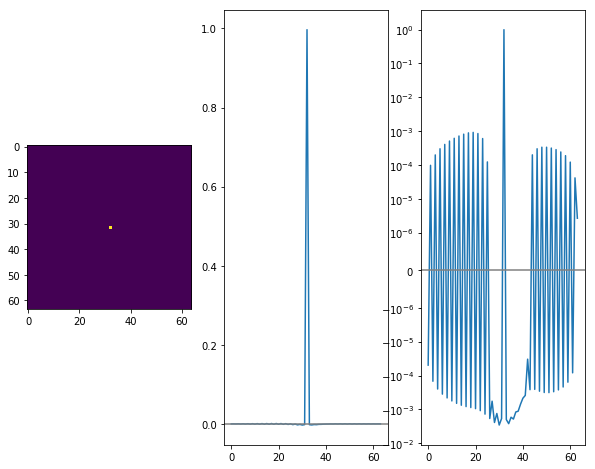

In [508]:
plt.imshow(ic1) #, cmap='RdBu', vmin=-0.05, vmax=0.05)
#plt.axis([cx-15,cx+15,cy-15,cy+15])
plt.subplot(1,3,2)
plt.plot(ic1[cy,:])
plt.axhline(0, color='0.5');
plt.subplot(1,3,3)
plt.plot(ic1[cy,:])
plt.yscale('symlog', linthreshy=1e-6);
plt.axhline(0, color='0.5');

In [607]:
ic1.sum(), np.sum(np.abs(ic1)), np.sqrt(np.sum(ic1**2)), psf1.sum()

(0.7071067811865475, 2.173278921777139, 0.9974098862997217, 1.0)

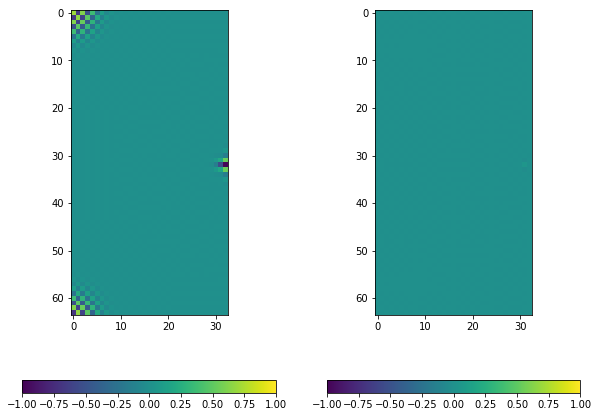

In [395]:
plt.subplot(1,2,1)
plt.imshow((P2 / D).real, vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.imshow((P2 / D).imag, vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal');

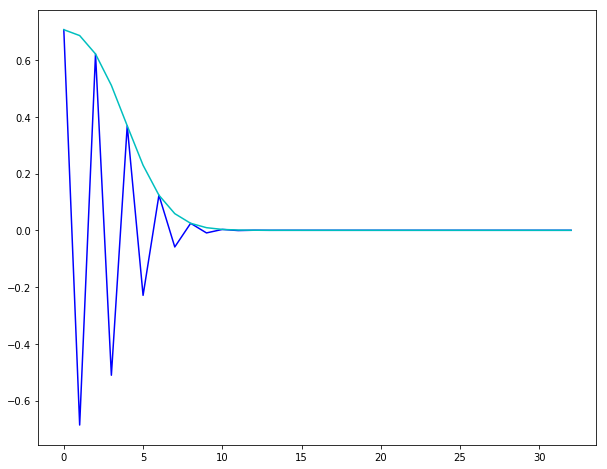

In [505]:
plt.plot((P2 / D).real[0,:], 'b-');
plt.plot(np.abs(P2/D)[0,:], 'c-');

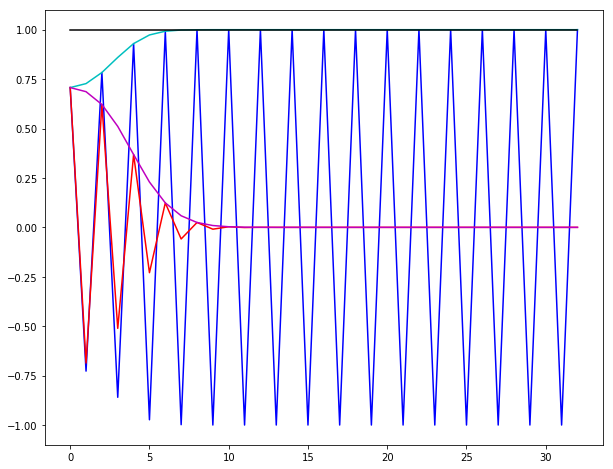

In [574]:
plt.plot((P1 / D).real[0,:], 'b-');
plt.plot(np.abs(P1/D)[0,:], 'c-');
plt.plot((P2 / D).real[0,:], 'r-');
plt.plot(np.abs(P2/D)[0,:], 'm-');

plt.plot(np.hypot(np.abs(P1/D)[0,:], np.abs(P2/D)[0,:]), 'k-');

In [396]:
ic2 = np.fft.irfft2(P2/D)
ic2.dtype, ic2.shape

(dtype('float64'), (64, 64))

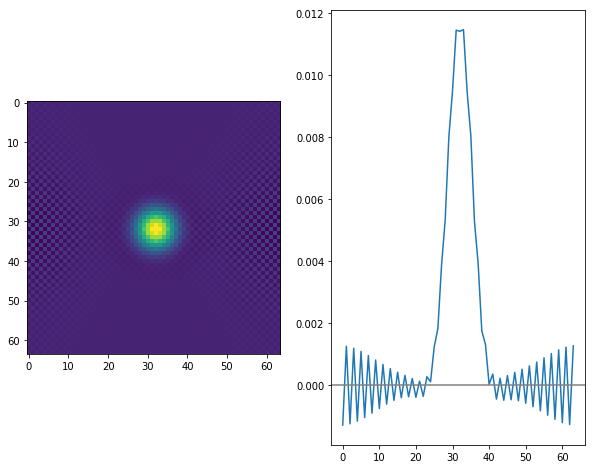

In [397]:
# this is the effective convolution filter to go from img2 to R.
plt.subplot(1,2,1)
plt.imshow(ic2)
plt.subplot(1,2,2)
plt.plot(ic2[cy,:]);
plt.axhline(0, color='0.5');

In [608]:
print('Range', ic2[cy,:].min(), ic2[cy,:].max())
ic2.sum(), np.sum(np.abs(ic2)), np.sqrt(np.sum(ic2**2))

Range -0.0012753796460955608 0.011460997979779614


(0.7071067811865475, 1.7155761546493156, 0.0719271764465696)

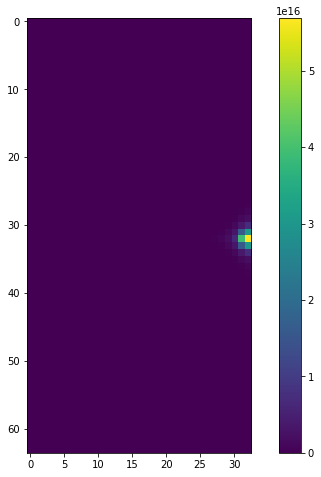

In [494]:
# N gets deconvolved by D; ie convolved with 1/D; what does that filter look like?
plt.imshow(1/D)
plt.colorbar();

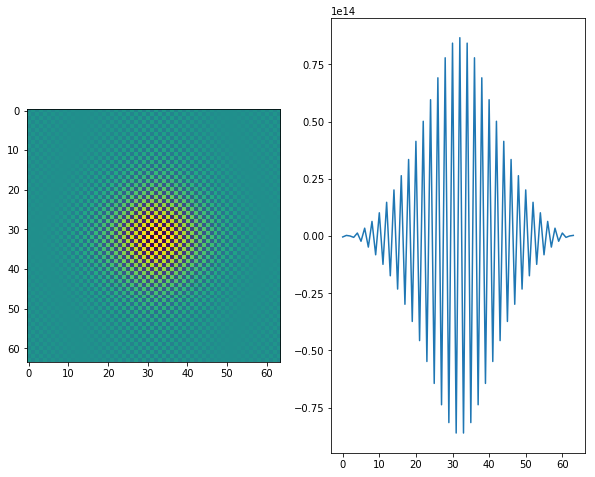

In [497]:
imginvD = np.fft.ifftshift(np.fft.irfft2(1./D))
plt.subplot(1,2,1)
plt.imshow(imginvD);
plt.subplot(1,2,2)
plt.plot(imginvD[cy,:]);

In [398]:
imgPR = np.fft.ifftshift(np.fft.irfft2(D))
imgPR.dtype, imgPR.shape

(dtype('float64'), (64, 64))

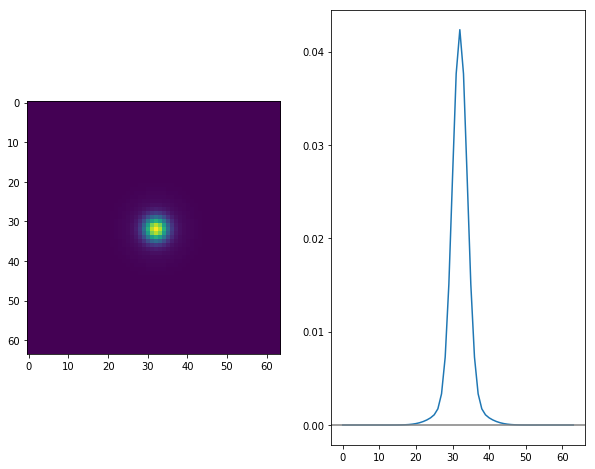

In [399]:
# This is the PSF of image R.
plt.subplot(1,2,1)
plt.imshow(imgPR)
plt.subplot(1,2,2)
plt.plot(imgPR[cy,:]);
plt.axhline(0, color='0.5');

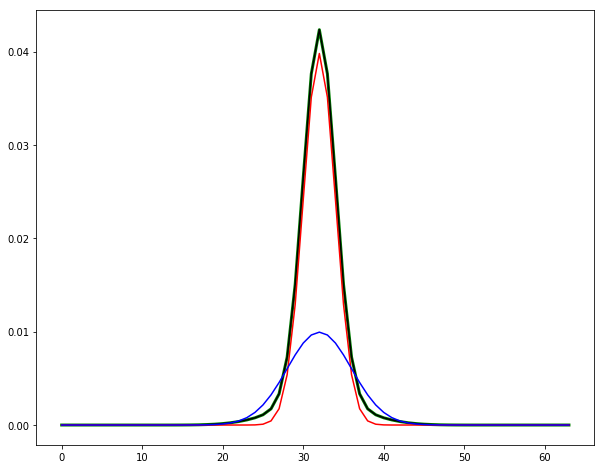

In [402]:
plt.plot(imgPR[cy,:], 'g', lw=3);
plt.plot(imgR[cy,:], color='k')
plt.plot(img1[cy,:], color='r')
plt.plot(img2[cy,:], color='b');

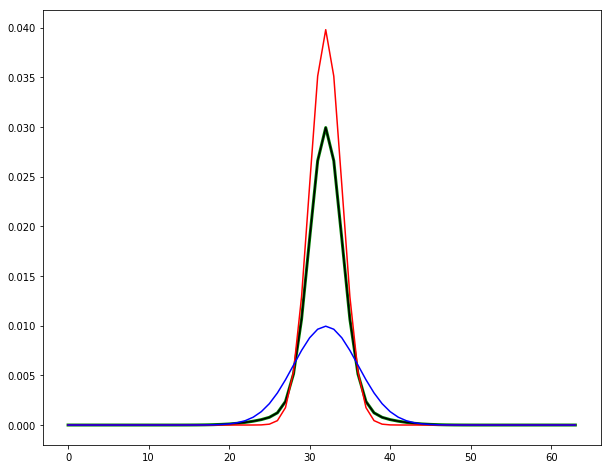

In [403]:
plt.plot(imgPR[cy,:] / np.sum(imgPR), 'g', lw=3);
plt.plot(imgR[cy,:] / np.sum(imgR), color='k')
plt.plot(img1[cy,:] / np.sum(img1), color='r')
plt.plot(img2[cy,:] / np.sum(img2), color='b');

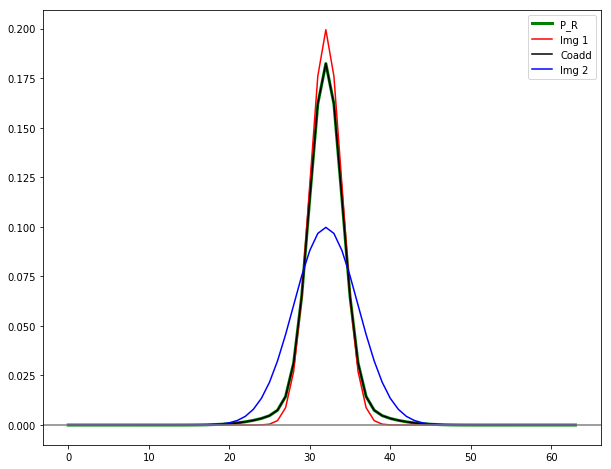

In [404]:
plt.plot(imgPR[cy,:] / np.sum(imgPR[cy,:]), 'g', lw=3, label='P_R');
plt.plot(img1[cy,:] / np.sum(img1[cy,:]), color='r', label='Img 1')
plt.plot(imgR[cy,:] / np.sum(imgR[cy,:]), color='k', label='Coadd')
plt.plot(img2[cy,:] / np.sum(img2[cy,:]), color='b', label='Img 2')
plt.legend()
plt.axhline(0, color='0.5');

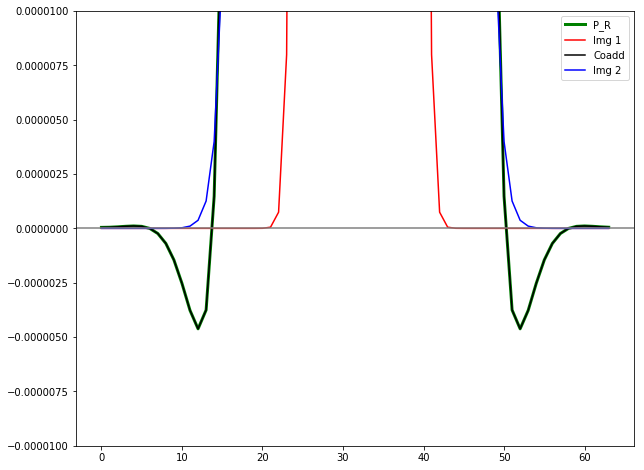

In [409]:
plt.plot(imgPR[cy,:] / np.sum(imgPR[cy,:]), 'g', lw=3, label='P_R');
plt.plot(img1[cy,:] / np.sum(img1[cy,:]), color='r', label='Img 1')
plt.plot(imgR[cy,:] / np.sum(imgR[cy,:]), color='k', label='Coadd')
plt.plot(img2[cy,:] / np.sum(img2[cy,:]), color='b', label='Img 2')
plt.legend()
plt.axhline(0, color='0.5');
plt.ylim(-1e-5, 1e-5);

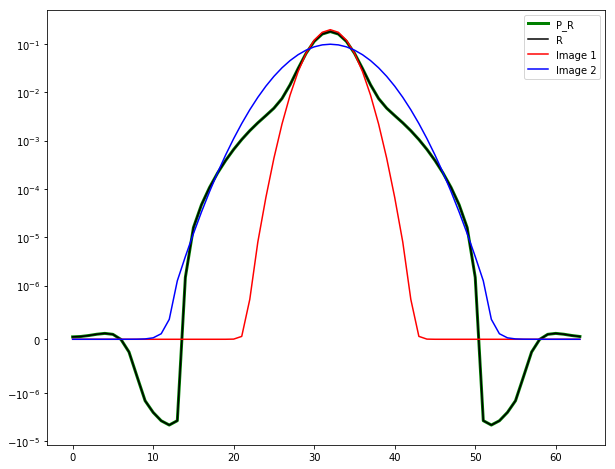

In [406]:
plt.plot(imgPR[cy,:] / np.sum(imgPR[cy,:]), 'g', lw=3, label='P_R');
plt.plot(imgR[cy,:] / np.sum(imgR[cy,:]), color='k', label='R')
plt.plot(img1[cy,:] / np.sum(img1[cy,:]), color='r', label='Image 1')
plt.plot(img2[cy,:] / np.sum(img2[cy,:]), color='b', label='Image 2')
plt.yscale('symlog', linthreshy=1e-6)
plt.legend();

Investigate noise performance -- does R really have uncorrelated pixels?

In [575]:
noise1 = np.random.normal(size=(H,W)) * sig_1
noise2 = np.random.normal(size=(H,W)) * sig_2

In [576]:
NM1 = np.fft.rfft2(noise1)
NM2 = np.fft.rfft2(noise2)
N = (F1 / sig_1**2) * (P1 * NM1) + (F2 / sig_2**2) * (P2 * NM2)

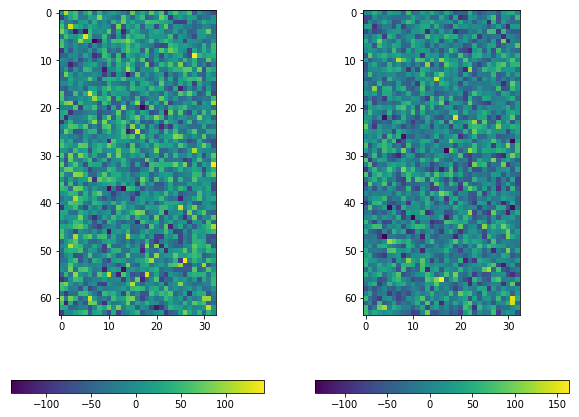

In [544]:
plt.subplot(1,2,1)
plt.imshow(NM1.real)
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.imshow(NM1.imag)
plt.colorbar(orientation='horizontal');

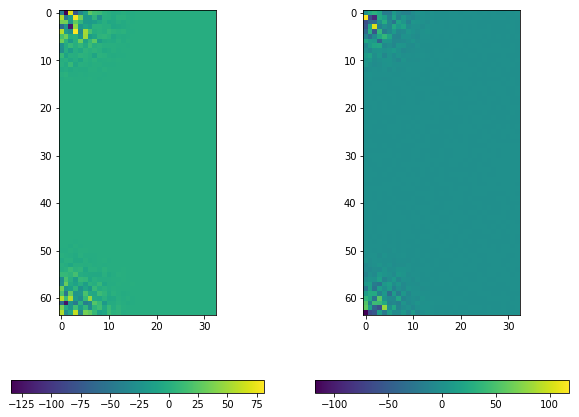

In [545]:
plt.subplot(1,2,1)
plt.imshow(N.real)
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.imshow(N.imag)
plt.colorbar(orientation='horizontal');

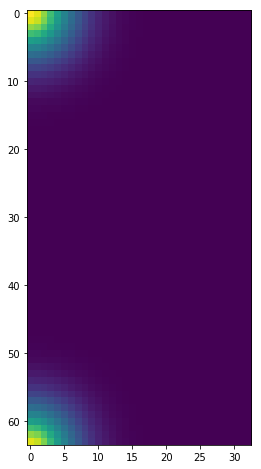

In [546]:
plt.imshow(D);

In [547]:
R = N/D
imgR = np.fft.irfft2(R)
imgR = np.fft.ifftshift(imgR)

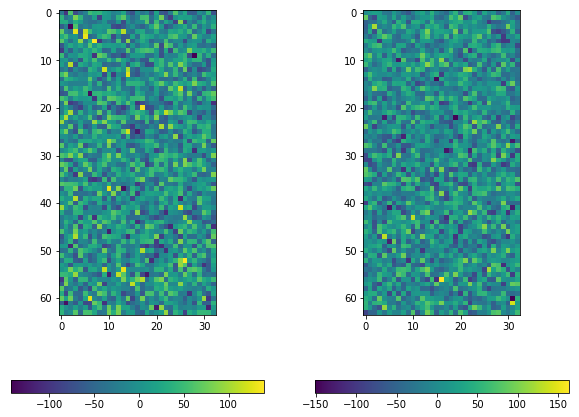

In [548]:
plt.subplot(1,2,1)
plt.imshow(R.real)
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.imshow(R.imag);
plt.colorbar(orientation='horizontal');

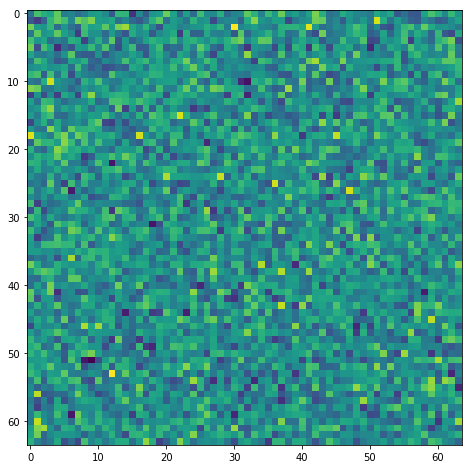

In [549]:
plt.imshow(imgR);

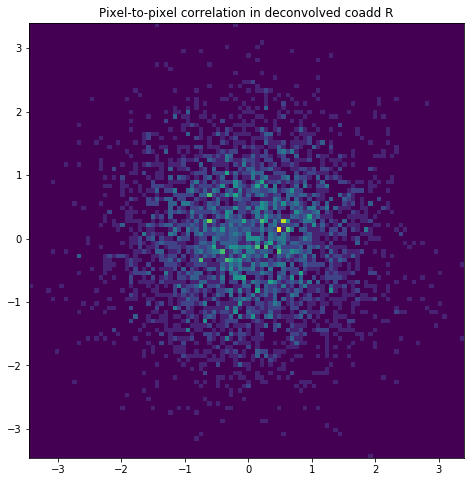

In [550]:
# Correlation between x-neighboring pixels
ha = dict(doclf=False, dohot=False, docolorbar=False, imshowargs=dict(aspect=1))
plothist(imgR[:-1,:].ravel(), imgR[1:,:].ravel(), **ha)
plt.title('Pixel-to-pixel correlation in deconvolved coadd R');

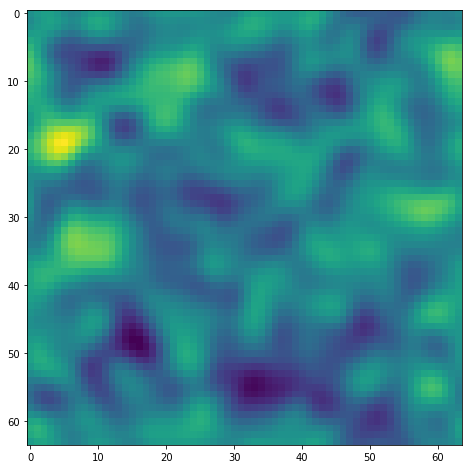

In [551]:
imgN = np.fft.irfft2(N)
imgN = np.fft.ifftshift(imgN)
plt.imshow(imgN);

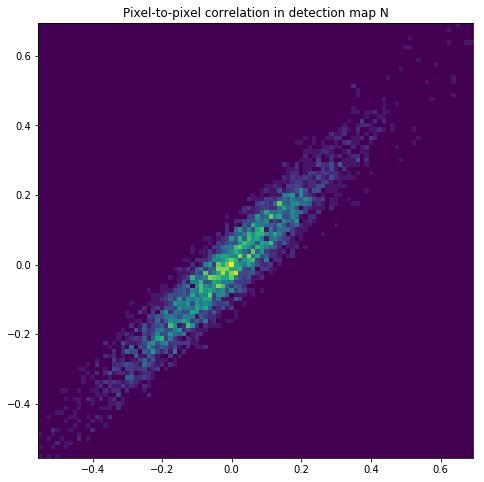

In [552]:
plothist(imgN[:-1,:].ravel(), imgN[1:,:].ravel(), **ha);
plt.title('Pixel-to-pixel correlation in detection map N');

In [553]:
# Show that deconvolving by D yields "just right" correction for correlations
Rx = N / (D**0.95)
imgRx = np.fft.irfft2(Rx)
imgRx = np.fft.ifftshift(imgRx)

Ry = N / (D**1.05)
imgRy = np.fft.irfft2(Ry)
imgRy = np.fft.ifftshift(imgRy)

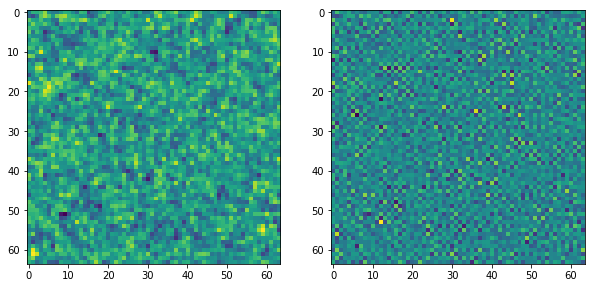

In [554]:
plt.subplot(1,2,1)
plt.imshow(imgRx);
plt.subplot(1,2,2)
plt.imshow(imgRy);

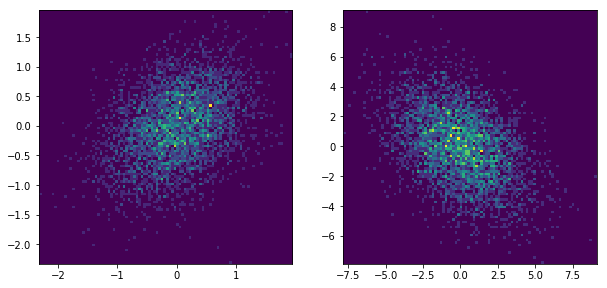

In [555]:
plt.subplot(1,2,1)
plothist(imgRx[:-1,:].ravel(), imgRx[1:,:].ravel(), **ha);
plt.subplot(1,2,2)
plothist(imgRy[:-1,:].ravel(), imgRy[1:,:].ravel(), **ha);

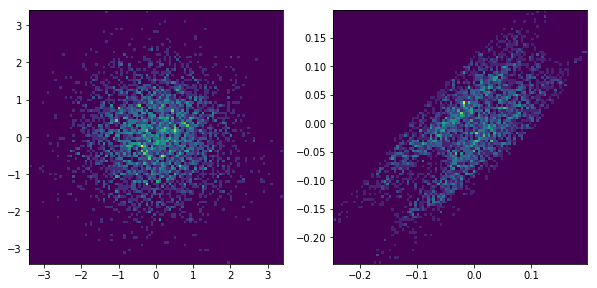

In [556]:
R1 = ((F1 / sig_1**2) * (P1 * NM1) / D)
R2 = ((F2 / sig_2**2) * (P2 * NM2) / D)
imgR1 = np.fft.ifftshift(np.fft.irfft2(R1))
imgR2 = np.fft.ifftshift(np.fft.irfft2(R2))
plt.subplot(1,2,1)
plothist(imgR1[:-1,:].ravel(), imgR1[1:,:].ravel(), **ha);
plt.subplot(1,2,2)
plothist(imgR2[:-1,:].ravel(), imgR2[1:,:].ravel(), **ha);

In [557]:
print(np.cov(imgR1[:-1,:].ravel(), imgR1[1:,:].ravel()))
print(np.cov(imgR2[:-1,:].ravel(), imgR2[1:,:].ravel()))
print(np.cov(imgR [:-1,:].ravel(), imgR [1:,:].ravel()))

[[ 9.91514374e-01 -8.81245774e-04]
 [-8.81245774e-04  9.92352787e-01]]
[[0.00510084 0.00347034]
 [0.00347034 0.00511259]]
[[0.99961146 0.00578152]
 [0.00578152 1.00002904]]


-0.0029511680485123553 0.9969954193952131
-0.0012753796460955608 0.011460997979779614


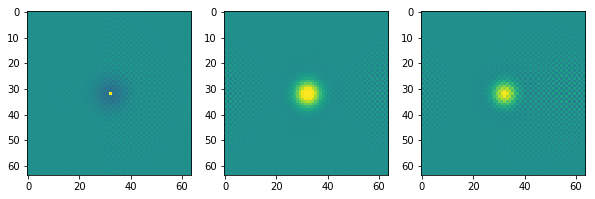

In [571]:
ic1 = np.fft.irfft2(P1/D)
ic2 = np.fft.irfft2(P2/D)
plt.subplot(1,3,1)
plt.imshow(ic1, vmin=-0.01, vmax=0.01);
plt.subplot(1,3,2)
plt.imshow(ic2, vmin=-0.01, vmax=0.01);
print(ic1.min(), ic1.max())
print(ic2.min(), ic2.max())
plt.subplot(1,3,3)
plt.imshow(ic1+ic2, vmin=-0.01, vmax=0.01);


In [589]:
# Draw a bunch of samples and look at covariances
Nsamples = 10000
cr = np.zeros(Nsamples)
c1 = np.zeros(Nsamples)
c2 = np.zeros(Nsamples)
for i in range(Nsamples):
    noise1 = np.random.normal(size=(H,W)) * sig_1
    noise2 = np.random.normal(size=(H,W)) * sig_2
    NM1 = np.fft.rfft2(noise1)
    NM2 = np.fft.rfft2(noise2)
    N = (F1 / sig_1**2) * (P1 * NM1) + (F2 / sig_2**2) * (P2 * NM2)
    R = N / D
    R1 = ((F1 / sig_1**2) * (P1 * NM1) / D)
    R2 = ((F2 / sig_2**2) * (P2 * NM2) / D)
    imgR1 = np.fft.ifftshift(np.fft.irfft2(R1))
    imgR2 = np.fft.ifftshift(np.fft.irfft2(R2))
    imgR  = np.fft.ifftshift(np.fft.irfft2(R ))
    C = np.cov(imgR1[:-1,:].ravel(), imgR1[1:,:].ravel())
    c1[i] = C[0,1]
    C = np.cov(imgR2[:-1,:].ravel(), imgR2[1:,:].ravel())
    c2[i] = C[0,1]
    C = np.cov(imgR[:-1,:].ravel(), imgR[1:,:].ravel())
    cr[i] = C[0,1]

(-0.004050263598623364, 0.0037926876956958025, -0.00024316704893661761)

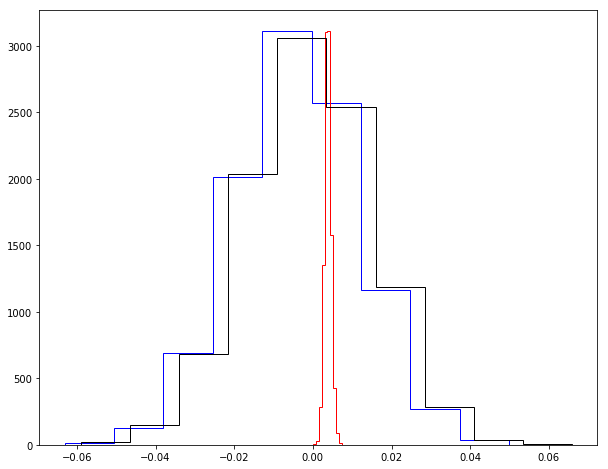

In [590]:
plt.hist(c1, histtype='step', color='b');
plt.hist(c2, histtype='step', color='r');
plt.hist(cr, histtype='step', color='k')
np.mean(c1), np.mean(c2), np.mean(cr) #, np.var(c1), np.var(c2), np.var(cr)

In [609]:
# Ignoring correlations, what about just the noise amplitude?
# If we've convolved by a PSF with negative lobes, we must be amplifying the noise, right?

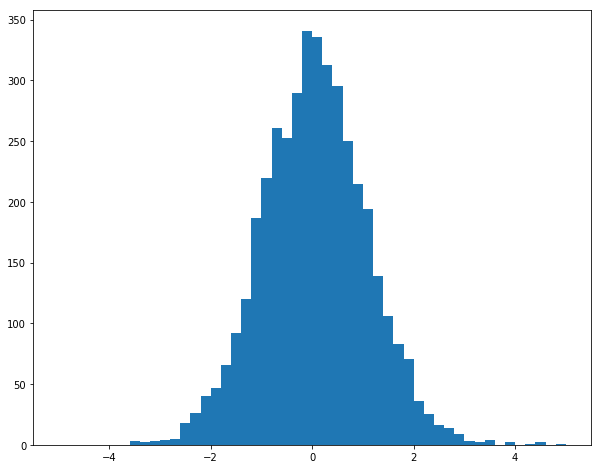

In [612]:
plt.hist(imgR.ravel(), range=(-5,5), bins=50);

In [613]:
imgR.std()

1.0338573878580477

Data + Noise

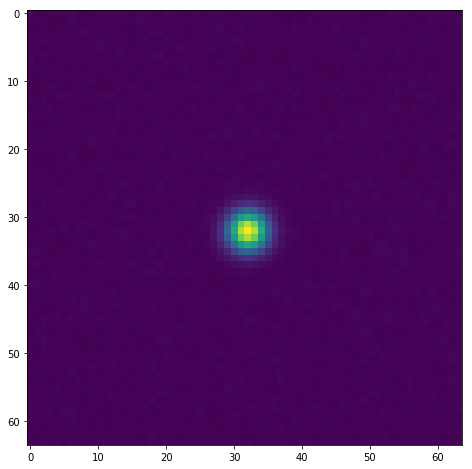

In [632]:
F = 10000.
noisy1 = img1*F + np.random.normal(size=(H,W)) * sig_1
noisy2 = img2*F + np.random.normal(size=(H,W)) * sig_2
NM1 = np.fft.rfft2(noisy1)
NM2 = np.fft.rfft2(noisy1)
N = (F1 / sig_1**2) * (P1 * NM1) + (F2 / sig_2**2) * (P2 * NM2)
plt.imshow(noisy1);

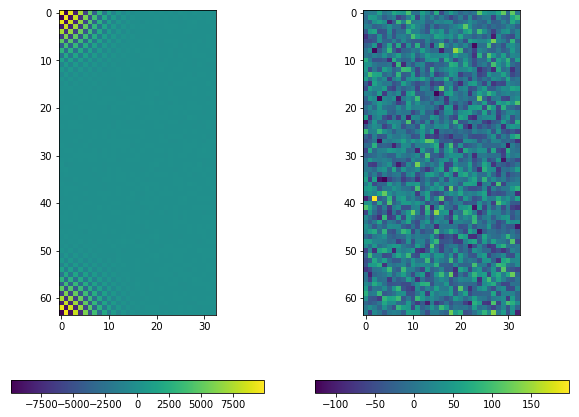

In [633]:
plt.subplot(1,2,1)
plt.imshow(NM1.real)
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.imshow(NM1.imag)
plt.colorbar(orientation='horizontal');

In [634]:
R = N/D
imgR = np.fft.irfft2(R)
imgR = np.fft.ifftshift(imgR)

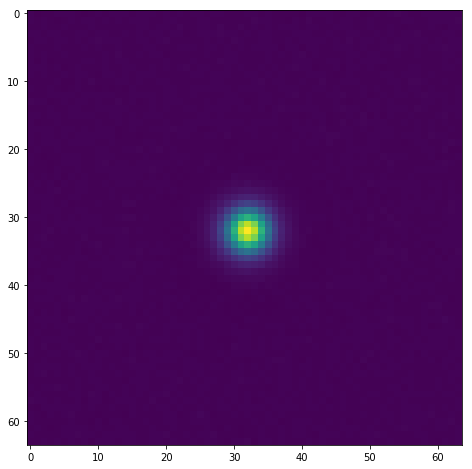

In [635]:
plt.imshow(imgR);

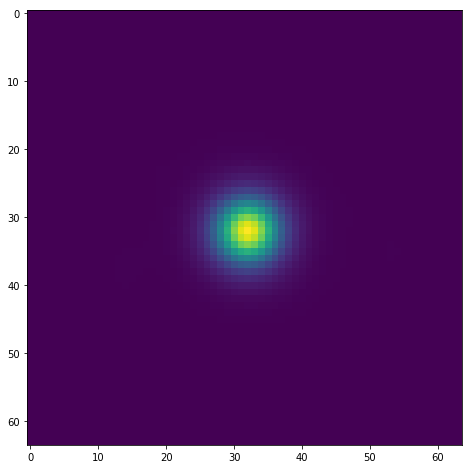

In [636]:
imgN = np.fft.irfft2(N)
imgN = np.fft.ifftshift(imgN)
plt.imshow(imgN);

In [637]:
np.sum(noisy1), np.sum(noisy2), np.sum(imgR)

(9934.527889156176, 9997.545513788806, 14049.544076618418)

In [631]:
np.sum(img1)*F, np.sum(np.random.normal(size=(H,W))*sig_1)

(100.0, -41.4296961551834)

In [640]:
np.std(noisy1.ravel()), np.std(noisy2.ravel()), np.std(imgR.ravel())

(21.91451342774838, 10.785707779674716, 27.431077681723295)

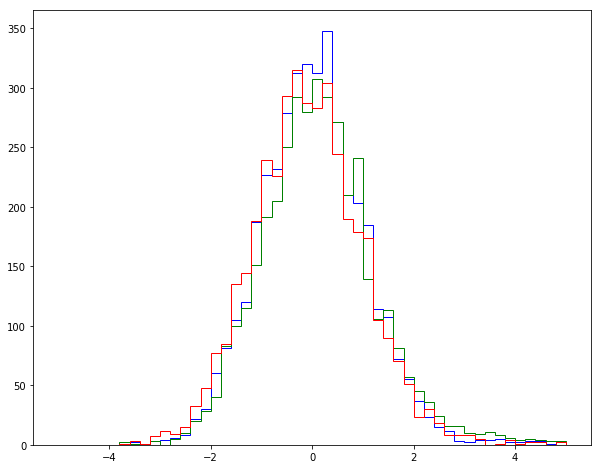

In [650]:
ha = dict(range=(-5,5), bins=50, histtype='step')
plt.hist(noisy1.ravel(), color='b', **ha)
plt.hist(noisy2.ravel(), color='g', **ha)
plt.hist(imgR.ravel(), color='r', **ha);

In [622]:
np.sqrt(4096)

64.0

In [651]:
# What's up with phases?

In [662]:
img1 = np.exp(-0.5 * ((xx-cx1)**2 + (yy-cy)**2)/psf_s1**2)
img1 /= np.sum(img1)

F3 = 1.
cx3 = cx1 + 0.5
psf_s3 = psf_s1
sig_3 = sig_1
img3 = np.exp(-0.5 * ((xx-cx3)**2 + (yy-cy)**2)/psf_s3**2)
img3 /= np.sum(img3)

In [654]:
psf3 = img3
P3 = np.fft.rfft2(psf3)
M3 = P3

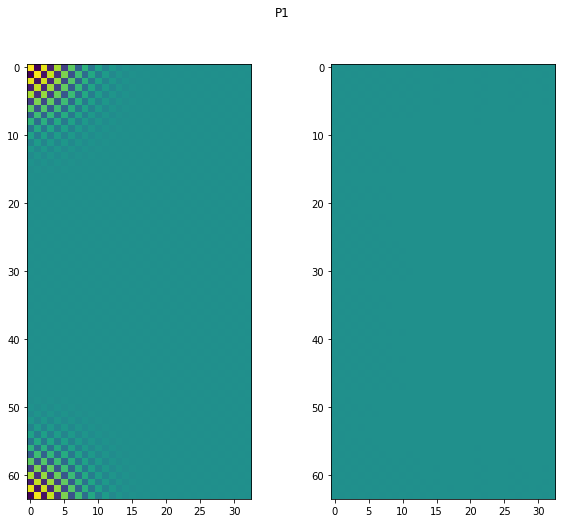

In [655]:
plt.subplot(1,2,1)
plt.imshow(P1.real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow(P1.imag, vmin=-1, vmax=1)
plt.suptitle('P1');

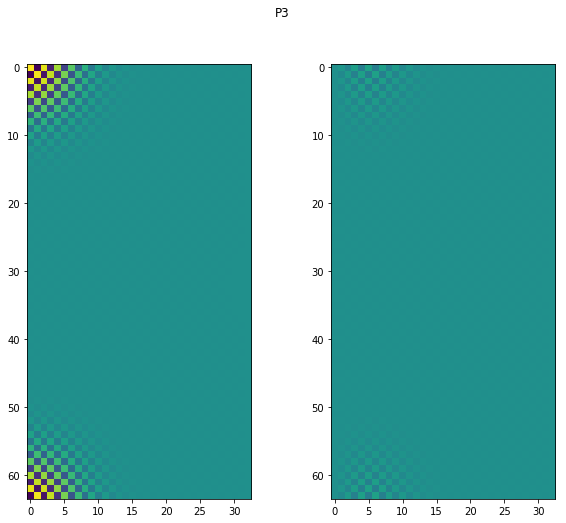

In [656]:
plt.subplot(1,2,1)
plt.imshow(P3.real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow(P3.imag, vmin=-1, vmax=1)
plt.suptitle('P3');

In [665]:
D = np.sqrt((F1**2 / sig_1**2) * np.abs(P1)**2 + (F3**2 / sig_3**2) * np.abs(P3)**2)

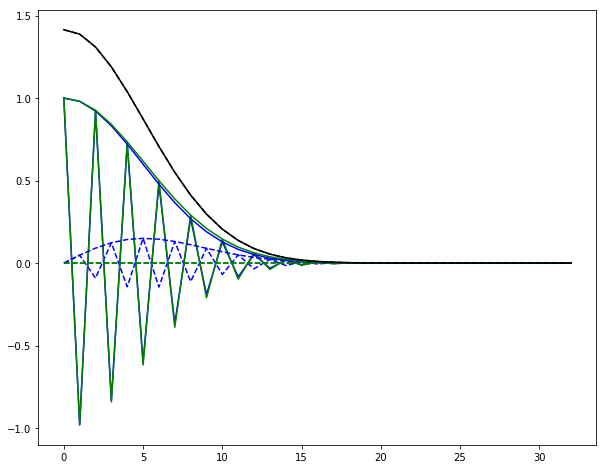

In [667]:
plt.plot(P3.real[0,:], 'b-')
plt.plot(P3.imag[0,:], 'b--')
plt.plot(P1.real[0,:], 'g-')
plt.plot(P1.imag[0,:], 'g--')

plt.plot(np.abs(P3.real[0,:]), 'b-')
plt.plot(np.abs(P3.imag[0,:]), 'b--')
plt.plot(np.abs(P1.real[0,:]), 'g-')
plt.plot(np.abs(P1.imag[0,:]), 'g--')

plt.plot(D[0,:].real, 'k-');
plt.plot(D[0,:].real, 'k--');

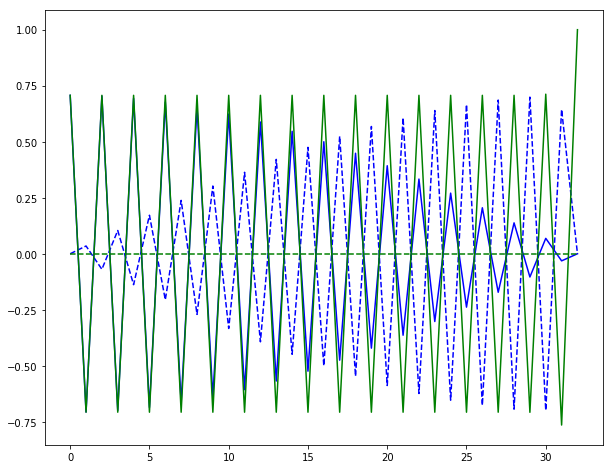

In [673]:
plt.plot((P3/D).real[0,:], 'b-')
plt.plot((P3/D).imag[0,:], 'b--')
plt.plot((P1/D).real[0,:], 'g-')
plt.plot((P1/D).imag[0,:], 'g--');

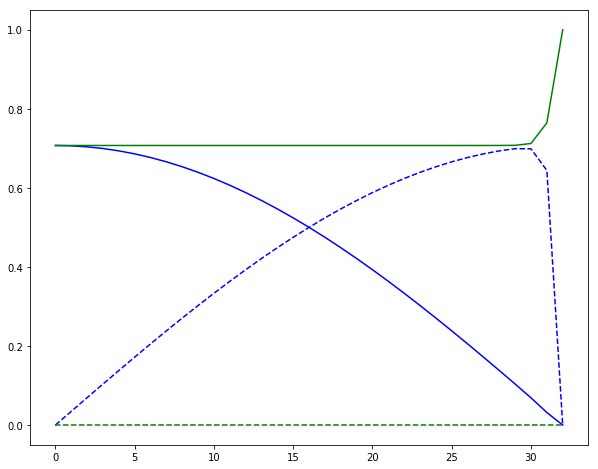

In [674]:
plt.plot(np.abs((P3/D).real)[0,:], 'b-')
plt.plot(np.abs((P3/D).imag)[0,:], 'b--')
plt.plot(np.abs((P1/D).real)[0,:], 'g-')
plt.plot(np.abs((P1/D).imag)[0,:], 'g--');

In [669]:
R = N/D
print(R.dtype, R.shape)
imgR = np.fft.irfft2(R)
imgR = np.fft.ifftshift(imgR)
print(imgR.dtype, imgR.shape)
Counter(np.sign(imgR).ravel())

complex128 (64, 33)
float64 (64, 64)


Counter({1.0: 2220, -1.0: 1876})

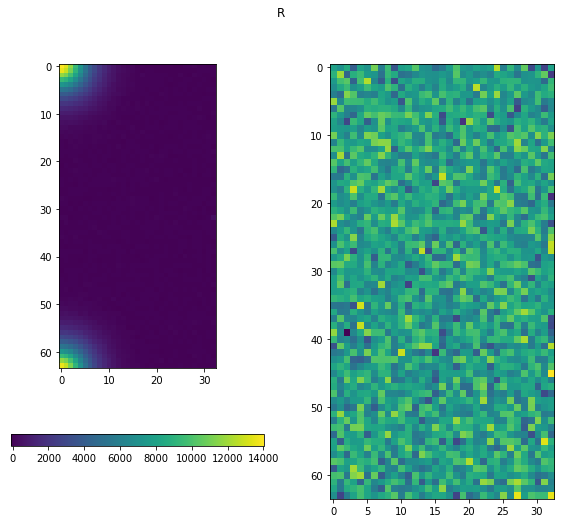

In [680]:
plt.subplot(1,2,1)
plt.imshow(R.real) #, vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.imshow(R.imag) #, vmin=-1, vmax=1)
plt.suptitle('R');

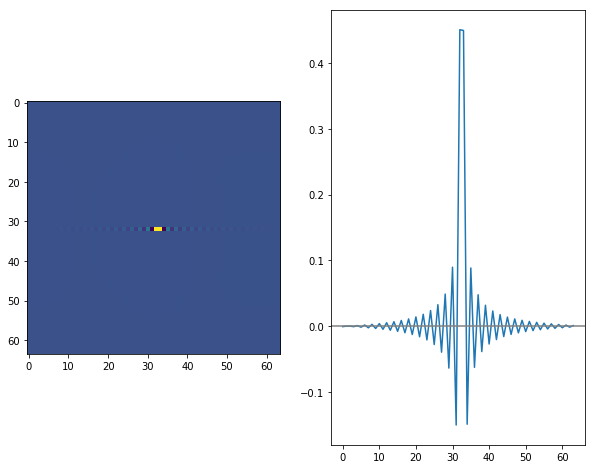

In [677]:
# ic3 is the effective convolution kernel to go from img3 to R
ic3 = np.fft.irfft2(P3/D)
plt.subplot(1,2,1)
plt.imshow(ic3)
plt.subplot(1,2,2)
plt.plot(ic3[cy,:])
plt.axhline(0, color='0.5');

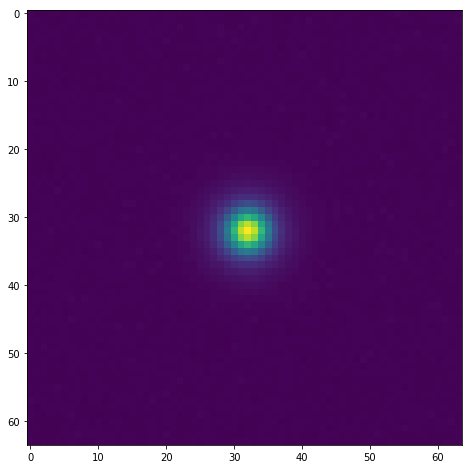

In [672]:
plt.imshow(imgR)